In [1]:
import numpy as np
import cv2
import pandas as pd
import pickle
import sklearn
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
os.chdir('C:\Digital Engineering\Gender Detection')

# Load the models

In [3]:
haar = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
# pickle files
mean =pickle.load(open('./model/mean_preprocess.pickle','rb'))
model_svm =pickle.load(open('./model_svm.pickle','rb'))
model_pca =pickle.load(open('./model/pca_50.pickle','rb'))

print ('Model Loaded Successfully')


Model Loaded Successfully


C:\Users\osama\anaconda3\envs\Chatterbot\lib\site-packages\sklearn\base.py:333: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [14]:
gender_pre = ['Male','Female']
font = cv2.FONT_HERSHEY_SIMPLEX

In [15]:
def pipeline_model(img,color='rgb'):
    
    # convert into gray scale
    
    if color == 'bgr':
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    else:
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
    # crop the face (using haar cascase classifier)
    
    faces = haar.detectMultiScale(gray,1.5,3)
    
    for x,y,w,h in faces:
        
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) # drawing rectangle
        
        # crop image
        
        roi = gray[y:y+h,x:x+w] 
        
        # normalization (0-1)
        
        roi = roi / 255.0
        
        # resize images (100,100)
        
        if roi.shape[1] > 100:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_AREA)
        else:
            roi_resize = cv2.resize(roi,(100,100),cv2.INTER_CUBIC)
            
        # Flattening (1x10000)
        
        roi_reshape = roi_resize.reshape(1,10000) # 1,-1
        
        # subptract with mean
        
        roi_mean = roi_reshape - mean
        
        #  get eigen image
        
        eigen_image = model_pca.transform(roi_mean)
        
        #  pass to ml model (svm)
        
        results = model_svm.predict_proba(eigen_image)[0]
        
        # p
        
        predict = results.argmax() # 0 or 1 
        score = results[predict]
        
        # step -11:
        
        text = "%s : %0.2f"%(gender_pre[predict],score)
        cv2.putText(img,text,(x,y),font,1,(0,255,0),2)
        
    return img

In [16]:
from PIL import Image
import matplotlib.image as mat_image

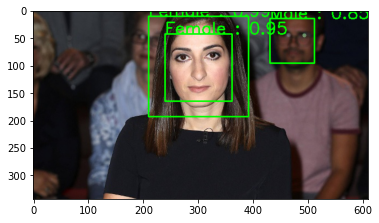

In [9]:
test_data_path = './test1.jpg'


color = 'bgr'
# step-1: read image
img = Image.open(test_data_path) # rgb

img
# step2: convert into array
img = np.array(img)
# step3: pass to pipeline model
img = pipeline_model(img)
plt.imshow(img)

# Apply to Videos

In [ ]:
cap = cv2.VideoCapture(path)

while True:
    ret, frame = cap.read() # bgr

    if ret == False:
        break

    frame = pipeline_model(frame,color='bgr')

    cv2.imshow('Gender Detector',frame)
    if cv2.waitKey(10) == ord('s'): # press s to exit  --#esc key (27), 
        break

cv2.destroyAllWindows()
cap.release()

In [7]:
import numpy as np
import cv2

cap = cv2.VideoCapture("C:/Digital Engineering/Gender Detection/video.mp4")

# Define the codec and create VideoWriter object
#fourcc = cv2.cv.CV_FOURCC(*'DIVX')
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
#out = cv2.VideoWriter('output.mp4', -1, 20.0, (640,480))

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,0)

        # write the flipped frame
        out.write(frame)

        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()